In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import json
import pickle

In [3]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)

In [4]:
dict_els = {}
for i in dataset['Composition'].values:
    el_list = re.findall('[A-Z][a-z]?', i)
    for el in el_list:
        if el in dict_els.keys():
            dict_els[el] += 1
        else:
            dict_els[el] = 1

Text(0.5, 1.0, 'Element count in reduced dataset')

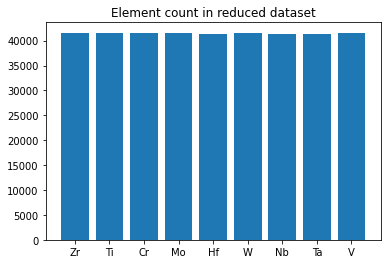

In [5]:
plt.bar(range(len(dict_els.keys())),list(dict_els.values()))
plt.xticks(range(len(dict_els.keys())),list(dict_els.keys()))
plt.title('Element count in reduced dataset')

# Results

In [6]:
with open('results.json','r') as fid:
    results_dict = json.load(fid)

In [7]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

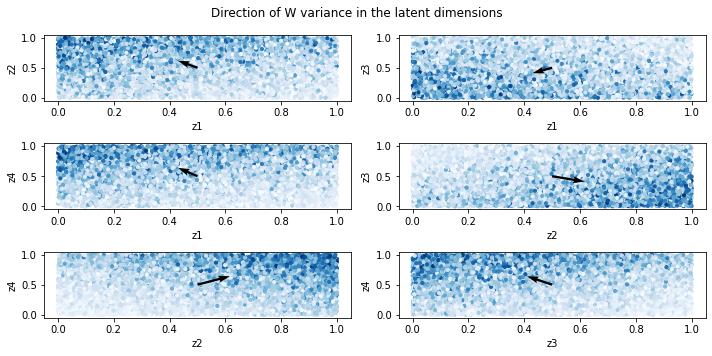

In [8]:
uniform_noise = np.array(results_dict['inverse']['constants']['uniform_noise'])
w_content =  np.array(results_dict['inverse']['constants']['w_content'])
dominant_dir = np.array(results_dict['inverse']['constants']['dominant_dir'])

from itertools import combinations
perm = combinations(np.arange(uniform_noise.shape[1]), 2)  
fig,ax = plt.subplots(3,2,figsize = (10,5))
ax = ax.flatten()
for k,i in enumerate(list(perm)):
    a,b = i
    ax[k].scatter(uniform_noise[:,a],uniform_noise[:,b],s = 10, c = w_content[:],cmap = 'Blues')
    ax[k].quiver(0.5,0.5,dominant_dir[a],dominant_dir[b],angles='xy', scale_units='xy', scale=1)
    ax[k].set_xlabel('z{}'.format(a+1))
    ax[k].set_ylabel('z{}'.format(b+1))

plt.suptitle('Direction of W variance in the latent dimensions')
plt.tight_layout()

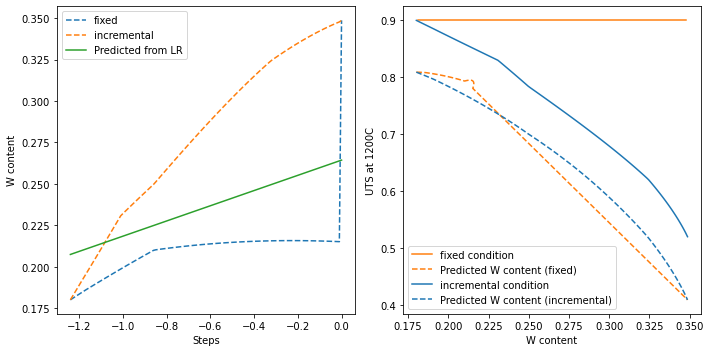

In [82]:
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax = ax.ravel()
fixed_bin = [True, False]
for bin in fixed_bin:
        i = int(bin)
        
        if bin:
            c = 'tab:orange'
            label = 'fixed'
            new_predicted_w = np.array(results_dict['inverse']['fixed']['predicted_w']),
            gen_w_content = np.array(results_dict['inverse']['fixed']['actual_w']),
            g_fake_data_fixed = np.array(results_dict['inverse']['fixed']['g_fake_data']),
            g_fake_data_uts = np.array(results_dict['inverse']['fixed']['g_fake_data_uts']),
            y = np.array(results_dict['inverse']['fixed']['y']),
            n_points = np.array(results_dict['inverse']['fixed']['x'])
            ax[1].axhline(y = y, xmin = 0.05, xmax = 0.95, color = c, label = '{} condition'.format(label))
            
        else:
            c = 'tab:blue'
            label = 'incremental'
            new_predicted_w = np.array(results_dict['inverse']['inc']['predicted_w']),
            gen_w_content = np.array(results_dict['inverse']['inc']['actual_w']),
            g_fake_data_fixed = np.array(results_dict['inverse']['inc']['g_fake_data']),
            g_fake_data_uts = np.array(results_dict['inverse']['inc']['g_fake_data_uts']),
            y = np.array(results_dict['inverse']['inc']['y']),
            n_points = np.array(results_dict['inverse']['inc']['x'])
            ax[1].plot(np.array(gen_w_content).reshape(-1), np.array(y).reshape(-1), color = c, label = '{} condition'.format(label))
        ax[0].plot(n_points.reshape(-1),np.array(gen_w_content).reshape(-1), linestyle='dashed', label = label)
        ax[1].plot(np.array(gen_w_content).reshape(-1), np.array(g_fake_data_uts).reshape(-1), color = c, linestyle = 'dashed', label = 'Predicted W content ({})'.format(label))
       
ax[0].plot(np.array(n_points).reshape(-1),np.array(new_predicted_w).reshape(-1), label = 'Predicted from LR')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('W content')
ax[1].set_xlabel('W content')
ax[1].set_ylabel('UTS at 1200C')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

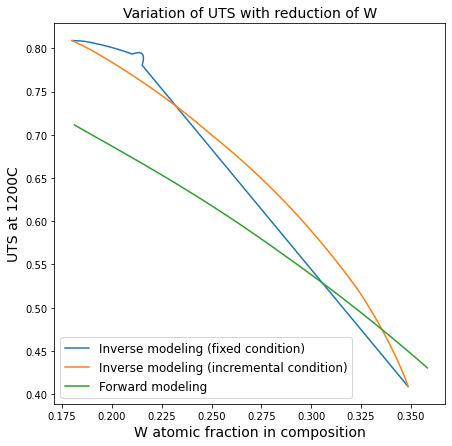

In [11]:
fig,ax = plt.subplots(figsize = (7,7))
inverse_uts_fixed = results_dict['inverse']['fixed']['g_fake_data_uts']
inverse_uts_inc = results_dict['inverse']['inc']['g_fake_data_uts']
inverse_w_fixed = results_dict['inverse']['fixed']['actual_w']
inverse_w_inc = results_dict['inverse']['inc']['actual_w']
forward_uts = results_dict['forward']['best_cand_uts']
forward_w = results_dict['forward']['w_content']
ax.plot(inverse_w_fixed, inverse_uts_fixed, label = 'Inverse modeling (fixed condition)')
ax.plot(inverse_w_inc, inverse_uts_inc, label = 'Inverse modeling (incremental condition)')
ax.plot(forward_w,forward_uts, label = 'Forward modeling')

ax.set_xlabel('W atomic fraction in composition', fontsize = 14)
ax.set_ylabel('UTS at 1200C', fontsize = 14)
ax.set_title('Variation of UTS with reduction of W',fontsize=14)
plt.legend(fontsize =12)


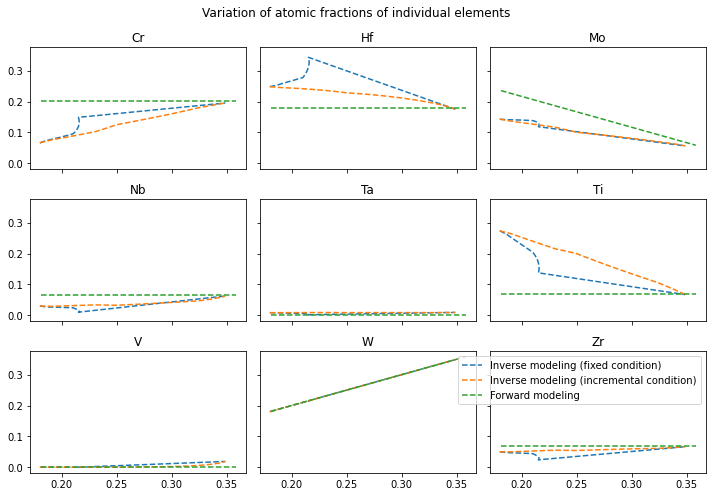

In [15]:
to_consider = results_dict['inverse']['constants']['to_consider']
inverse_comps_fixed = np.array(results_dict['inverse']['fixed']['g_fake_data'])
inverse_comps_inc = np.array(results_dict['inverse']['inc']['g_fake_data'])
forward_comps = np.array(results_dict['forward']['best_cands'])
fig,ax = plt.subplots(3,3, figsize = (10,7), sharex = True, sharey=True)
ax = ax.flatten()
for k,el in enumerate(to_consider):
    i = np.argwhere(el_list==el).item()
    ax[k].plot(inverse_w_fixed, inverse_comps_fixed[:,i], label = 'Inverse modeling (fixed condition)', linestyle = 'dashed')
    ax[k].plot(inverse_w_inc, inverse_comps_inc[:,i], label = 'Inverse modeling (incremental condition)', linestyle = 'dashed')
    ax[k].plot(forward_w, forward_comps[:,i], label = 'Forward modeling', linestyle = 'dashed')

    ax[k].set_title(el)
fig.suptitle('Variation of atomic fractions of individual elements')
plt.tight_layout()
plt.legend()